In [167]:
folder="/content/drive/MyDrive/解密AI黑盒子分享/"

In [168]:
import jieba
import random
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as plt_font
twfont1 = plt_font.FontProperties(fname=folder+"字型/kaiu.ttf")

In [169]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from gensim.models import word2vec

In [171]:
seq_length=5

In [172]:
with open("/content/drive/MyDrive/解密AI黑盒子分享/資料集/歌詞.txt", 'r', encoding='UTF-8') as f:
  file_list = f.readlines()

In [173]:
data_x=[jieba.lcut(text) for text in file_list]

In [174]:
model_w2v = word2vec.Word2Vec(data_x, size=128,iter=20,sg=1,min_count=0)

In [175]:
print(model_w2v)

Word2Vec(vocab=13623, size=128, alpha=0.025)


In [176]:
raw_text=""
for line in file_list:
  raw_text+=line
text=jieba.lcut(raw_text)

In [177]:
chars = sorted(list(set(text)))
len(chars)

13623

In [178]:
chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
n_chars = len(chars)
dataX = [] # N x seq_length
dataY = [] # N x 1
one_hot=np.zeros(n_chars)
for i in range(len(text) - seq_length):
  seq_in  = text[i:i + seq_length]
  seq_out   = text[i + seq_length]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])

In [179]:
dataX[0],dataY[0],int_to_char[dataY[0]]

([10775, 13346, 5258, 6127, 8825], 4632, '心情')

In [180]:
def text2vector(text):
  #input用來儲存語句的單字向量
  inputs = []
  #將語句以空白字元切割成單字word
  for word in text:
    #如果這個單字在單字庫內，就將單字轉one hot encode放到input中
    inputs.append(model_w2v.wv.get_vector(int_to_char[word]))
  return np.array(inputs)

In [181]:
class MyDataset(Dataset):
  def __init__(self):
    self.data=np.array(dataX)
    self.label=np.array(dataY)
  def __getitem__(self, index):
    return torch.tensor(text2vector(self.data[index])), torch.tensor(self.label[index])
  def __len__(self): 
    return len(self.data)

In [182]:
TrainDS=MyDataset()
TrainDL=DataLoader(dataset=TrainDS,batch_size=100,shuffle=False,drop_last=True)

In [183]:
class LSTM(nn.Module):
  def __init__(self, InputNode, HiddenNode, LayerNum, OutputNode,dropout):
    super(LSTM, self).__init__()
    self.Cell = nn.LSTM(InputNode, HiddenNode, LayerNum, batch_first=True,dropout=dropout,bidirectional=True)
    self.Bn=nn.BatchNorm1d(HiddenNode*2)
    self.fc1=nn.Linear(HiddenNode*2,HiddenNode*2)
    self.fc2 = nn.Linear(HiddenNode*2, OutputNode)
  def forward(self, x):
    Cellout, hx = self.Cell(x, None)
    x=self.Bn(Cellout[:,-1,:])
    x=self.fc1(x)
    x=self.Bn(x)
    output=self.fc2(x)
    return output

In [184]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [185]:
InputNode=128
HiddenNode=512
LayerNum=2
OutputNode=n_chars
dropout=0.2
Net=LSTM(InputNode, HiddenNode, LayerNum, OutputNode,dropout).to(device)
LossFun= torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(Net.parameters())
Time_Step = seq_length
Step_L=[]

In [190]:
Net.train()
Step_L=[]
for epoch in range(20):
  for data,label in TrainDL:
    data= data.reshape(-1,seq_length,InputNode).to(device)
    optim.zero_grad()
    Yh = Net(data.float())
    loss = LossFun(Yh, label.long().to(device))
    Step_L.append(loss.item())
    loss.backward()
    optim.step()
    display.clear_output(wait=True)
    print("回合：",epoch+1,"損失函數",loss.item())

回合： 20 損失函數 0.2565022110939026


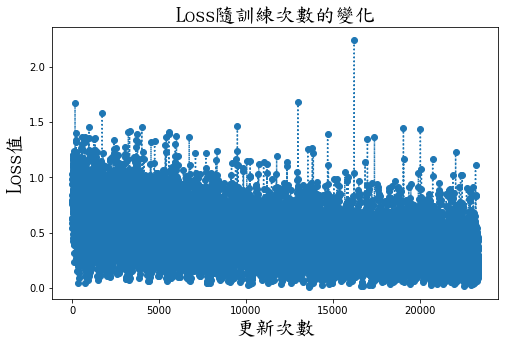

In [191]:
plt.figure(figsize=(8,5))
plt.title("Loss隨訓練次數的變化",fontproperties=twfont1,fontsize=20) 
plt.xlabel("更新次數",fontproperties=twfont1,fontsize=20) 
plt.ylabel("Loss值",fontproperties=twfont1,fontsize=20)
plt.plot(Step_L,":o")
plt.show()
torch.save(Net, folder+"資料集/rnngen.pth")

In [192]:
def is_end(c):
    end_tokens = ['。', '？', '！', '.', '?', '!','\n']
    return c in end_tokens

def to_prob(vec):
    s = sum(vec)
    return [v / s for v in vec]

In [195]:
char_to_int[" "],char_to_int["\n"]

(1, 0)

In [197]:
int_to_char[0],int_to_char[1],int_to_char[2],int_to_char[3],int_to_char[4]

('\n', ' ', '!', "'", '(')

In [ ]:
Net.eval()
start = np.random.randint(0, n_chars-1)
#char = chars[start]
char="沒有"
cnt = 0
output=[]
outputvector=[]
with torch.no_grad():
  while cnt < 10:
    output.append(char)
    outputvector.append(model_w2v.wv.get_vector(char))
    print("第",cnt,"句：",output)
    testdata=np.array(outputvector)
    TestYh=Net(torch.tensor(testdata.reshape(1,len(output),-1)).to(device))
    values, indices=TestYh.topk(100, dim=1, largest=True, sorted=True)
    index=indices.squeeze().cpu().numpy()
    for i in range(100):
      if index[i]==0 or index[i]==1:
        values[0,i]=values[0,i]/10
    pred = to_prob(torch.softmax(values, dim=1).cpu().numpy()[0])
    for i  in range(10):
      print(i,int_to_char[index[i]],end="|")
    print()
    char = int_to_char[np.random.choice(index, p=pred)]
    print("選出",char) 
    if is_end(char):
      start = np.random.randint(0, n_chars - 1)
      print()
      cnt += 1

In [ ]:
TestYh

tensor([[  4.2166,   4.9545, -16.4598,  ..., -11.1944,  -2.4464,  -8.3090]],
       device='cuda:0')

In [ ]:
#隨機產生一個開始詞
start = np.random.randint(0, n_chars-1)
pattern = chars[start]
cnt = 0
while cnt < 10: 
  seq_in = np.array(pattern)
  seq_in = seq_in.reshape(1, -1) # batch_size = 1
  seq_in = Variable(torch.LongTensor(seq_in))
  pred = model(seq_in)
  pred = to_prob(F.softmax(pred, dim=1).data[0].numpy()) # turn into probability distribution
  char = np.random.choice(chars, p=pred)                 # pick char based on probability instead of always picking the highest value
  char_idx = char_to_int[char]
  print(char, end='')
  pattern.append(char_idx)
  pattern = pattern[1:]
  if is_end(char):
    if restart_seq:
      start = np.random.randint(0, n_patterns - 1)
      pattern = patterns[start]
      print()
      cnt += 1 
    
  if not restart_seq:
    print()